In [ ]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

In [ ]:
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras import layers , models, regularizers , metrics , optimizers , callbacks
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp

In [ ]:
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

In [ ]:
data[0] , normalized_data[0]

(array([1.9553102 , 0.06745261], dtype=float32),
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.6779888 , -0.36787164], dtype=float32)>)

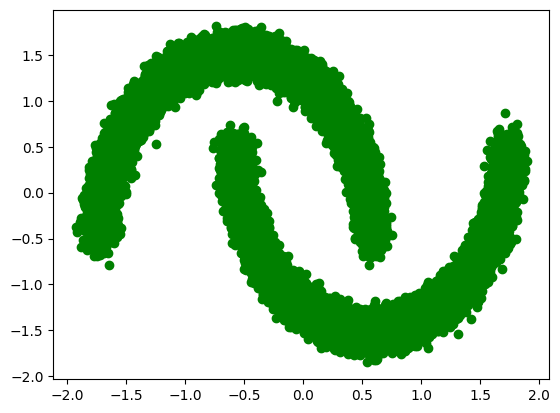

In [ ]:
plt.scatter(normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green");

In [ ]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])


In [ ]:
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)


In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="/content/drive/MyDrive/06_NORMALISING_FLOW/Training_Output/generated_img_%03d.png" % (epoch)
            )

img_generator_callback = ImageGenerator(num_samples=3000)


In [ ]:
model.fit( normalized_data , batch_size=BATCH_SIZE , epochs=EPOCHS , callbacks=[tensorboard_callback, img_generator_callback])

In [ ]:
x, z, samples = img_generator_callback.generate()

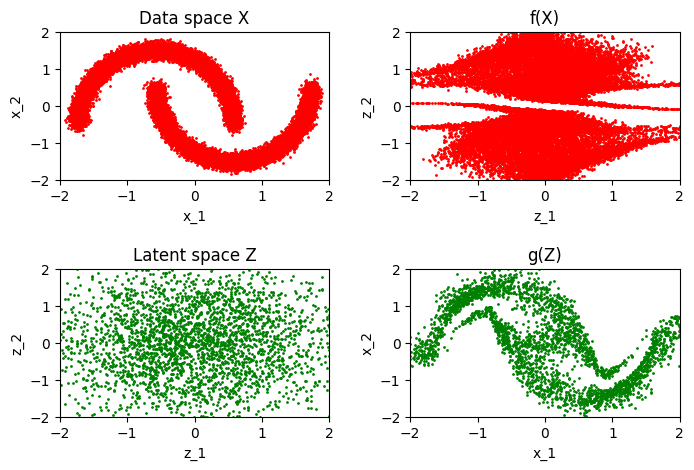

In [ ]:
img_generator_callback.display(x, z, samples)